In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# arima imports
import pmdarima as pm
import statsmodels.tsa.api as tsa
from pmdarima.model_selection import train_test_split
from pmdarima.arima.utils import ndiffs, nsdiffs

# Set wide fig size for plots
plt.rcParams['figure.figsize']=(12,3)

In [4]:
df = pd.read_csv('Data/all_ChicagoCrime.csv.gz', index_col=['Datetime'])
df.head()

,ID,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Latitude,Longitude
Datetime,,,,,,,,,,,
2001-01-01 01:00:00,1326041,BATTERY,SIMPLE,RESIDENCE,False,False,1624,16.0,NaN,41.957850,-87.749185
2001-01-01 13:00:00,1319931,BATTERY,SIMPLE,RESIDENCE,False,True,825,8.0,NaN,41.783892,-87.684841
2001-01-01 13:00:00,1324743,GAMBLING,ILLEGAL ILL LOTTERY,STREET,True,False,313,3.0,NaN,41.780412,-87.611970
2001-01-01 01:00:00,1310717,CRIMINAL DAMAGE,TO VEHICLE,STREET,False,False,2424,24.0,NaN,42.012391,-87.678032
2001-01-01 01:00:00,1318099,BATTERY,SIMPLE,RESIDENCE PORCH/HALLWAY,False,True,214,2.0,NaN,41.819538,-87.620020


In [9]:
df.index.dtype

dtype('O')

In [10]:
# Converting the index as date
df.index = pd.to_datetime(df.index)
df.index

DatetimeIndex(['2001-01-01 01:00:00', '2001-01-01 13:00:00',
               '2001-01-01 13:00:00', '2001-01-01 01:00:00',
               '2001-01-01 01:00:00', '2001-01-01 01:00:00',
               '2001-01-01 01:00:00', '2001-01-01 01:00:00',
               '2001-01-01 01:00:00', '2001-01-01 01:00:00',
               ...
               '2022-12-31 12:41:00', '2022-12-31 00:42:00',
               '2022-12-31 00:44:00', '2022-12-31 00:45:00',
               '2022-12-31 12:45:00', '2022-12-31 12:50:00',
               '2022-12-31 12:50:00', '2022-12-31 00:52:00',
               '2022-12-31 12:52:00', '2022-12-31 12:59:00'],
              dtype='datetime64[ns]', name='Datetime', length=7713109, freq=None)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7713109 entries, 2001-01-01 01:00:00 to 2022-12-31 12:59:00
Data columns (total 11 columns):
 #   Column                Dtype  
---  ------                -----  
 0   ID                    int64  
 1   Primary Type          object 
 2   Description           object 
 3   Location Description  object 
 4   Arrest                bool   
 5   Domestic              bool   
 6   Beat                  int64  
 7   District              float64
 8   Ward                  float64
 9   Latitude              float64
 10  Longitude             float64
dtypes: bool(2), float64(4), int64(2), object(3)
memory usage: 603.2+ MB


# You will compare the crime count forecast for Theft

For each of your selected crimes, perform the following steps to develop a forecast.

- Transform the data to obtain a time series of the crime count per month
- Check for and address null values.
- Decompose the Time series to detect seasonality and decide whether to use a seasonal model or not

In [16]:
#filter the data for theft
ts = df.loc[df['Primary Type']=='THEFT','Primary Type']
# Resample for business day with 'M'
ts = ts.resample('M').size()
ts

Datetime
2001-01-31    7867
2001-02-28    6669
2001-03-31    7766
2001-04-30    7702
2001-05-31    8420
              ... 
2022-08-31    5244
2022-09-30    5117
2022-10-31    5242
2022-11-30    4717
2022-12-31    4413
Freq: M, Name: Primary Type, Length: 264, dtype: int64

In [17]:
ts.isna().sum()

0

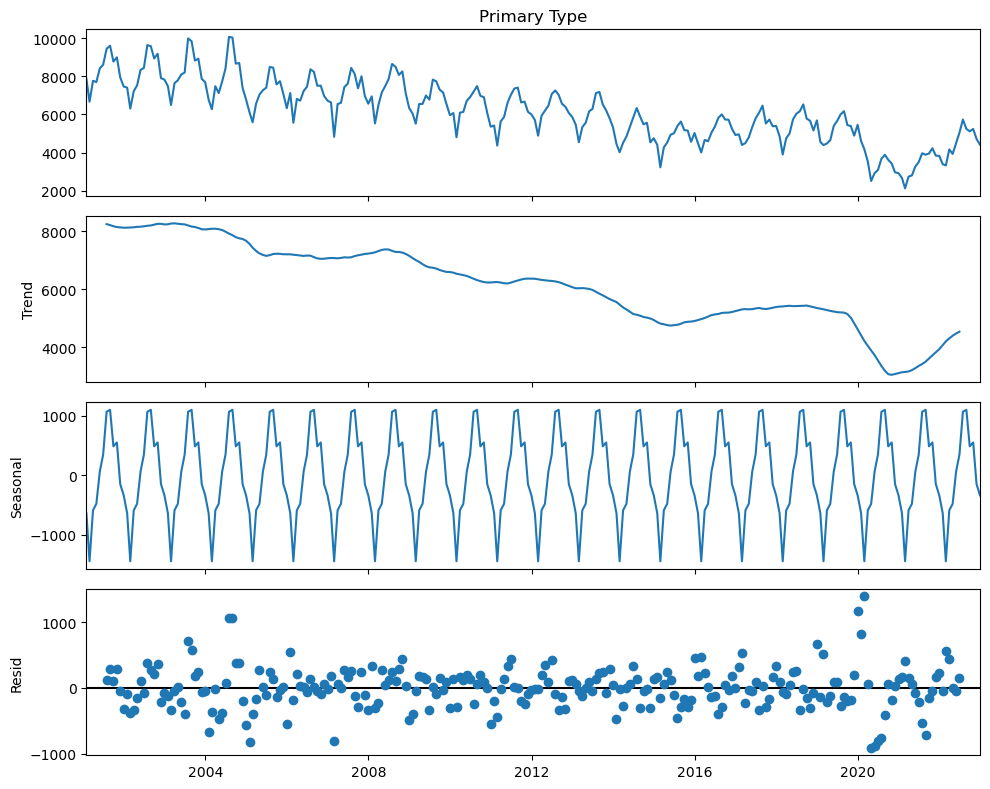

In [27]:
decomp = tsa.seasonal_decompose(ts)
fig= decomp.plot()
fig.set_size_inches(10,8)
fig.tight_layout()

In [30]:
# How big is the seasonal component
seasonal_delta = decomp.seasonal.max() - decomp.seasonal.min()

# How big is the seasonal component relative to the time series?
print(f"The seasonal component is {seasonal_delta} which is ~{seasonal_delta/(ts.max()-ts.min()) * 100 :.2f}% of the variation in time series.")

The seasonal component is 2549.9880952380954 which is ~32.08% of the variation in time series.


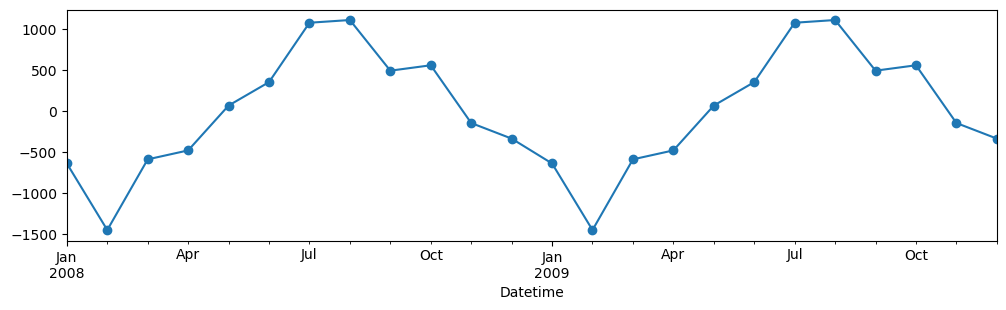

In [31]:
# Narrow down the date range of the plot
seasonal = decomp.seasonal
ax = seasonal.loc['2008': '2009'].plot(marker = 'o')

There are 12 points between peaks, indicating a seasonal period of 12 months. 
- Determine if nonseasonal and/or seasonal differencing is required
- Use the ACF and PACF plots of stationarity data to estimate initial orders
- Split the time series into training and test data (Remember we want to predict 6 months)

In [32]:
# determine d
d = ndiffs(ts)
print (f'd = {d}')
# Determine D
D = nsdiffs(ts, m =12)
print(f'D = {D}')

d = 1
D = 0


In [34]:
#​​# Difference the data
ts_diff = ts.diff().dropna()

In [35]:
def plot_acf_pacf(ts, nlags=40, figsize=(10, 5), 
                  annotate_sig=False, alpha=.05,
                 acf_kws={}, pacf_kws={},  
                  annotate_seas=False, m = None,
                 seas_color='black'):
    
    fig, axes = plt.subplots(nrows=2, figsize=figsize)

    
    # Sig lags line style
    sig_vline_kwargs = dict( ls=':', lw=1, zorder=0, color='red')

    # ACF
    tsa.graphics.plot_acf(ts, ax=axes[0], lags=nlags, **acf_kws)
    
    ## Annotating sig acf lags
    if annotate_sig == True:
        sig_acf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='ACF')
        for lag in sig_acf_lags:
            axes[0].axvline(lag,label='sig', **sig_vline_kwargs )

    # PACF
    tsa.graphics.plot_pacf(ts,ax=axes[1], lags=nlags, **pacf_kws)
    
    ## Annotating sig pacf lags
    if annotate_sig == True:
        ## ANNOTATING SIG LAGS
        sig_pacf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='PACF')
        for lag in sig_pacf_lags:
            axes[1].axvline(lag, label='sig', **sig_vline_kwargs)

    ### ANNOTATE SEASONS
    if annotate_seas == True:
        # Ensure m was defined
        if m is None:
            raise Exception("Must define value of m if annotate_seas=True.")

        ## Calculate number of complete seasons to annotate
        n_seasons = nlags//m 

        # Seasonal Lines style
        seas_vline_kwargs = dict( ls='--',lw=1, alpha=.7, color=seas_color, zorder=-1)
        
        ## for each season, add a line
        for i in range(1, n_seasons+1):
            axes[0].axvline(m*i, **seas_vline_kwargs, label="season")
            axes[1].axvline(m*i, **seas_vline_kwargs, label="season")

    fig.tight_layout()
    
    return fig

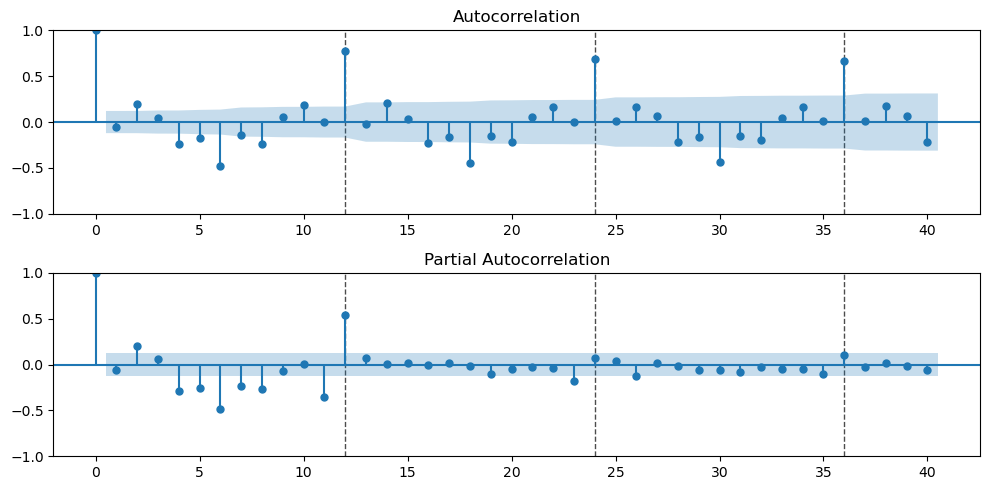

In [36]:
# We can use our function to highlight the seasonal lags by adding the arguments
plot_acf_pacf(ts_diff, annotate_seas=True, m = 12);

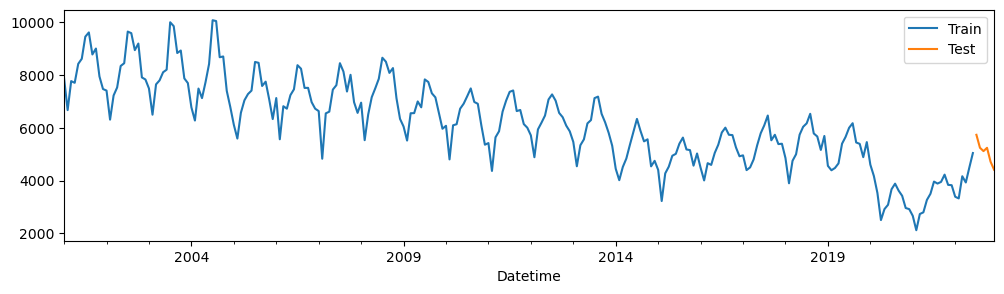

In [37]:
# we want to predict 6 months
train, test = train_test_split(ts, test_size=6)
ax = train.plot(label='Train')
test.plot(ax=ax, label='Test')
ax.legend();

In [38]:
# Orders for non seasonal components
p = 0  # nonseasonal AR
d = 1  # nonseasonal differencing
q = 0  # nonseasonal MA

# Orders for seasonal components
P = 1  # Seasonal AR
D = 0  # Seasonal differencing
Q = 1  # Seasonal MA
m = 12 # Seasonal period

sarima = tsa.ARIMA(train, order = (p,d,q), seasonal_order=(P,D,Q,m)).fit()

In [39]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

def regression_metrics_ts(ts_true, ts_pred, label="", verbose=True, output_dict=False,):
    # Get metrics
    mae = mean_absolute_error(ts_true, ts_pred)
    mse = mean_squared_error(ts_true, ts_pred)
    rmse = mean_squared_error(ts_true, ts_pred, squared=False)
    r_squared = r2_score(ts_true, ts_pred)
    mae_perc = mean_absolute_percentage_error(ts_true, ts_pred) * 100

    if verbose == True:
        # Print Result with label
        header = "---" * 20
        print(header, f"Regression Metrics: {label}", header, sep="\n")
        print(f"- MAE = {mae:,.3f}")
        print(f"- MSE = {mse:,.3f}")
        print(f"- RMSE = {rmse:,.3f}")
        print(f"- R^2 = {r_squared:,.3f}")
        print(f"- MAPE = {mae_perc:,.2f}%")

    if output_dict == True:
        metrics = {
            "Label": label,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R^2": r_squared,
            "MAPE(%)": mae_perc,
        }
        return metrics

In [40]:
def plot_forecast(ts_train, ts_test, forecast_df, n_train_lags=None, 
                  figsize=(10,4), title='Comparing Forecast vs. True Data'):
    ### PLot training data, and forecast (with upper/,lower ci)
    fig, ax = plt.subplots(figsize=figsize)

    # setting the number of train lags to plot if not specified
    if n_train_lags==None:
        n_train_lags = len(ts_train)
            
    # Plotting Training  and test data
    ts_train.iloc[-n_train_lags:].plot(ax=ax, label="train")
    ts_test.plot(label="test", ax=ax)

    # Plot forecast
    forecast_df['mean'].plot(ax=ax, color='green', label="forecast")

    # Add the shaded confidence interval
    ax.fill_between(forecast_df.index, 
                    forecast_df['mean_ci_lower'],
                   forecast_df['mean_ci_upper'],
                   color='green', alpha=0.3,  lw=2)

    # set the title and add legend
    ax.set_title(title)
    ax.legend();
    
    return fig, ax

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 239.726
- MSE = 85,243.366
- RMSE = 291.965
- R^2 = 0.517
- MAPE = 4.88%


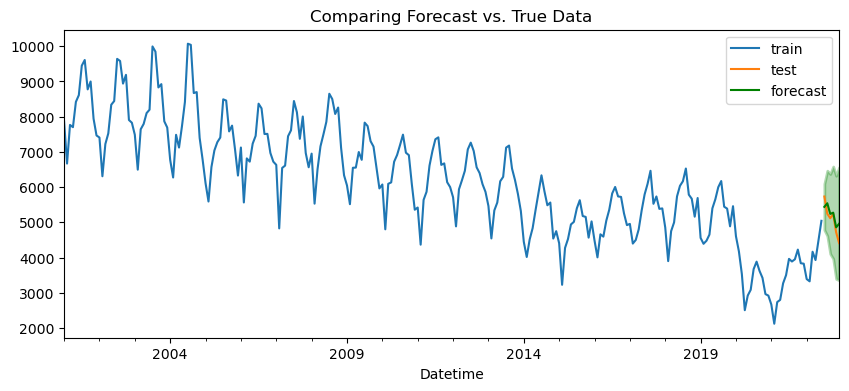

In [41]:
# Obtain summary of forecast as dataframe
forecast_df = sarima.get_forecast(len(test)).summary_frame()
# Plot the forecast with true values
plot_forecast(train, test, forecast_df)
# Obtain metrics
regression_metrics_ts(test, forecast_df["mean"])

In [60]:
# Default auto_arima will select model based on AIC score
auto_model = pm.auto_arima(
    train,
    seasonal=True,  
    m=12,
    trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=0.48 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=4050.524, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=3791.710, Time=0.20 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=3914.631, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=4048.603, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=4050.805, Time=0.06 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=3774.214, Time=0.45 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=3743.907, Time=1.20 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=3743.960, Time=0.71 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=2.46 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=3742.900, Time=1.11 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=3870.719, Time=0.51 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=3913.736, Time=0.21 sec
 ARIMA(0,1,0)(1,0,2)[12] intercept   : AIC=3754.859, Time=0.82 sec
 ARIMA(2,1,0)(1,0,2)[12] inte

In [61]:
# the auto_arima will store our best nonseasonal and seasonal orders separtely
ns_order=auto_model.order
s_order=auto_model.seasonal_order

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 211.162
- MSE = 72,806.759
- RMSE = 269.827
- R^2 = 0.587
- MAPE = 4.27%


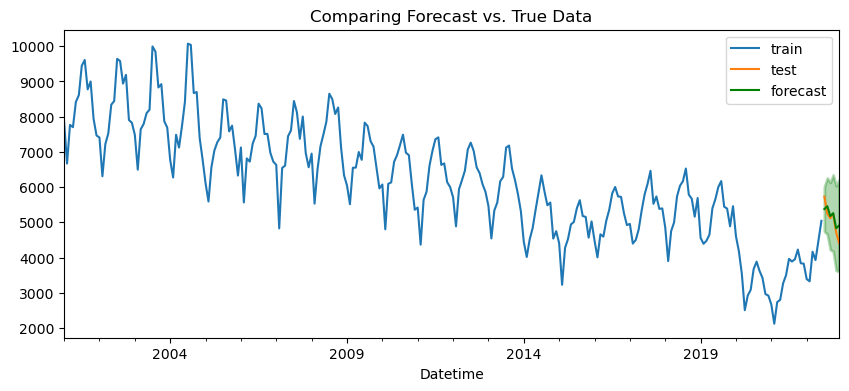

In [62]:
# Use auto_arima parameters to fit an ARIMA
auto_model = tsa.ARIMA(train, order=ns_order, seasonal_order=s_order).fit()


# Obtain forecast as a dataframe with confidence intervals
forecast_df = auto_model.get_forecast(steps=len(test)).summary_frame()
# Call the custom function to plot the forecasts with confidence intervals and true values
plot_forecast(train, test, forecast_df);
# Obtain metrics
regression_metrics_ts(test, forecast_df['mean'])

### The auto tuned ARIMA(1,1,0)(1,0,2)[12] is better than the manual model, as auto model shows higher R^2 and lower MAPE
- Obtain summary and diagnostic plots of the best model
- Make true future forecasts using the entire dataset (for dates beyond the entire ts)

In [63]:
# Obtain summary of the best model from auto_arima
auto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                       
=============================================================================================
Dep. Variable:                          Primary Type   No. Observations:                  258
Model:             ARIMA(1, 1, 0)x(1, 0, [1, 2], 12)   Log Likelihood               -1865.634
Date:                               Fri, 27 Oct 2023   AIC                           3741.268
Time:                                       22:08:44   BIC                           3759.013
Sample:                                   01-31-2001   HQIC                          3748.404
                                        - 06-30-2022                                         
Covariance Type:                                 opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2251      0.046     -4.934      0.000      -0.315      -0.136
ar.S.L12       0.9778      0.008    120.048      0.000       0.962       0.994
ma.S.L12      -0.5771      0.059     -9.815      0.000      -0.692      -0.462
ma.S.L24      -0.1202      0.068     -1.758      0.079      -0.254       0.014
sigma2      1.038e+05   7353.299     14.120      0.000    8.94e+04    1.18e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                30.54
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               0.80   Skew:                            -0.44
Prob(H) (two-sided):                  0.31   Kurtosis:                         4.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

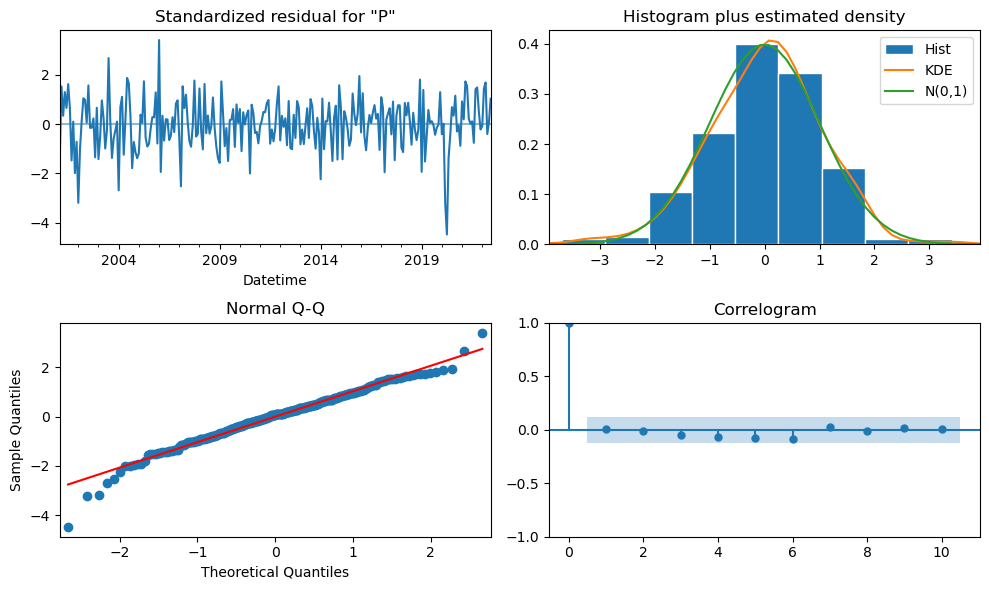

In [64]:
# Obtain diagnostic plots
fig = auto_model.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()

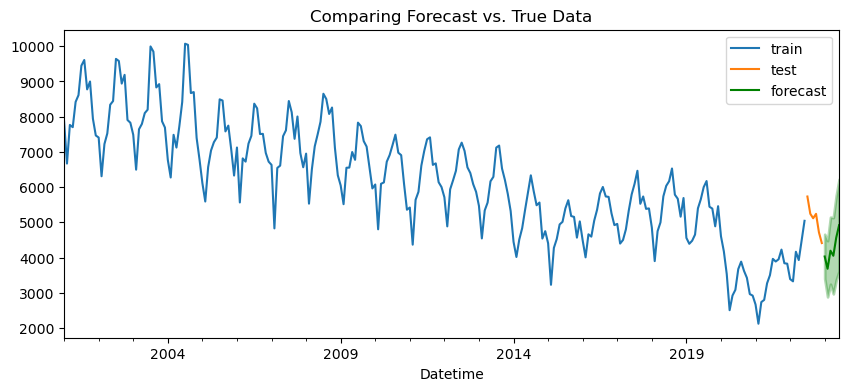

In [65]:
final_model = tsa.ARIMA(ts, order=ns_order, seasonal_order=s_order).fit()
# Obtain future forecasts beyond test data
forecast_df  = final_model.get_forecast(len(test)).summary_frame()
plot_forecast(train,test,forecast_df);

- Calculate the predicted net change in the number (raw counts) of this type of crime from the beginning of the forecast to the end.
- Convert the raw delta into a percent change.

In [71]:
starting_value = forecast_df['mean'].iloc[0]
final_value = forecast_df['mean'].iloc[-1]
change = final_value - starting_value
print(f' start:{starting_value}\n end:{final_value}\n change:{change}')

 start:4031.3759552919355
 end:4920.784847487454
 change:889.4088921955181


In [72]:
perc_change = (change / starting_value) * 100
perc_change

22.062166914202148

# You will compare the crime count forecast for Battery

In [74]:
#filter the data for battery
ts = df.loc[df['Primary Type']=='BATTERY','Primary Type']
# Resample for business day with 'M'
ts = ts.resample('M').size()
ts

Datetime
2001-01-31    6527
2001-02-28    6042
2001-03-31    7662
2001-04-30    8328
2001-05-31    8887
              ... 
2022-08-31    3740
2022-09-30    3723
2022-10-31    3501
2022-11-30    3083
2022-12-31    3009
Freq: M, Name: Primary Type, Length: 264, dtype: int64

In [75]:
ts.isna().sum()

0

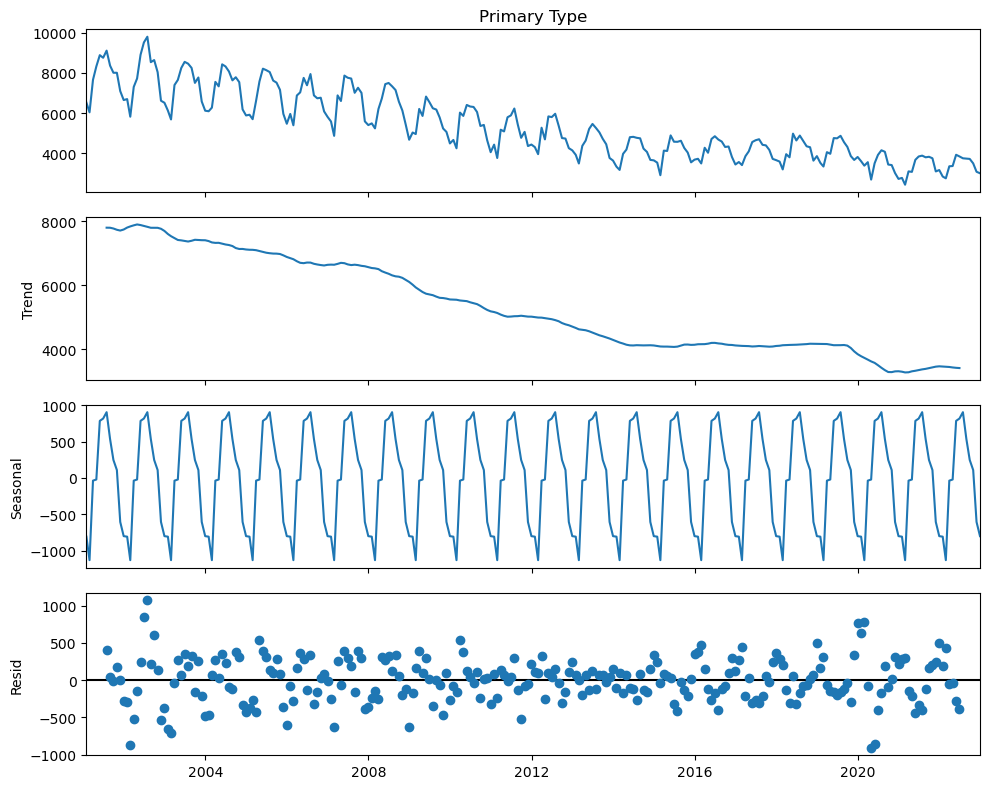

In [76]:
decomp = tsa.seasonal_decompose(ts)
fig= decomp.plot()
fig.set_size_inches(10,8)
fig.tight_layout()

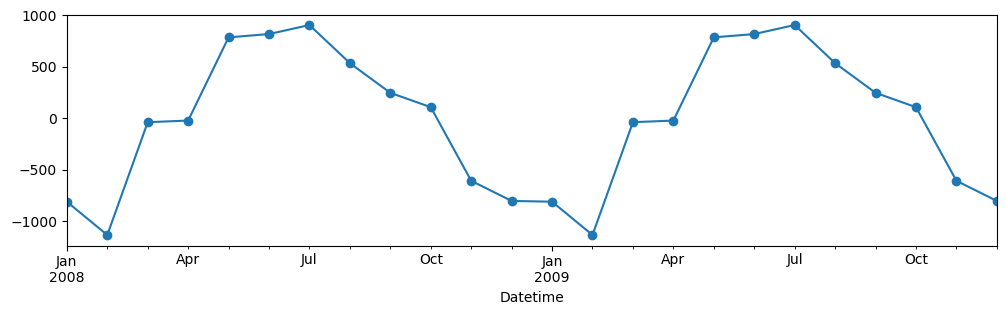

In [77]:
# Narrow down the date range of the plot
seasonal = decomp.seasonal
ax = seasonal.loc['2008': '2009'].plot(marker = 'o')

In [78]:
# determine d
d = ndiffs(ts)
print (f'd = {d}')
# Determine D
D = nsdiffs(ts, m =12)
print(f'D = {D}')

d = 1
D = 0


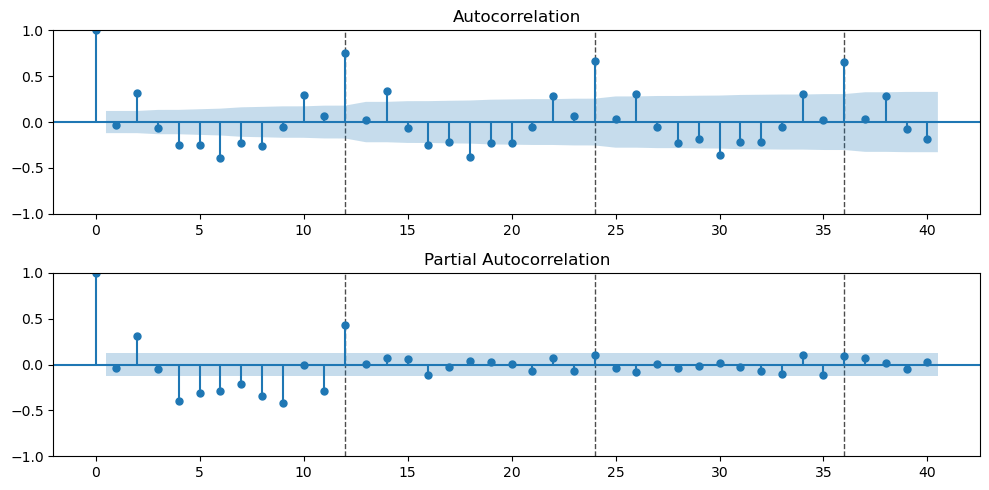

In [79]:
#​​# Difference the data
ts_diff = ts.diff().dropna()
# We can use our function to highlight the seasonal lags by adding the arguments
plot_acf_pacf(ts_diff, annotate_seas=True, m = 12);

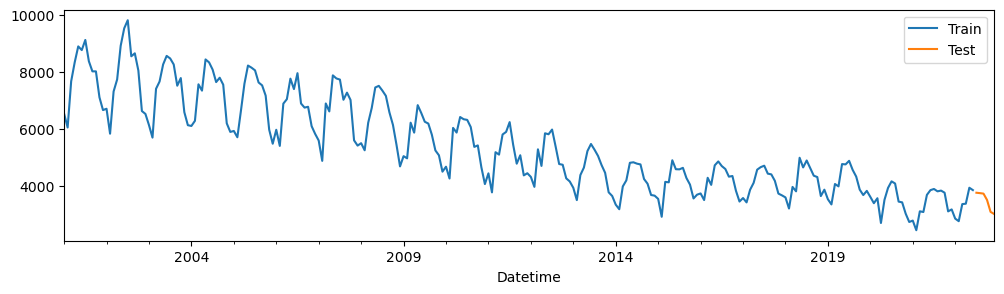

In [80]:
# we want to predict 6 months
train, test = train_test_split(ts, test_size=6)
ax = train.plot(label='Train')
test.plot(ax=ax, label='Test')
ax.legend();

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 134.557
- MSE = 21,336.520
- RMSE = 146.070
- R^2 = 0.780
- MAPE = 3.92%


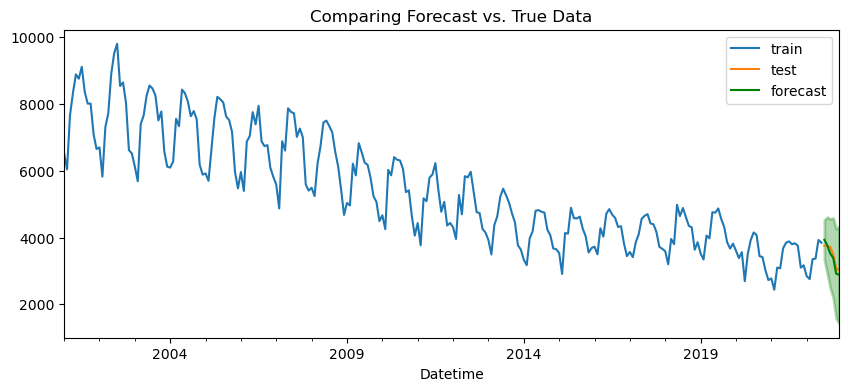

In [81]:
# Orders for non seasonal components
p = 0  # nonseasonal AR
d = 1  # nonseasonal differencing
q = 0  # nonseasonal MA

# Orders for seasonal components
P = 1  # Seasonal AR
D = 0  # Seasonal differencing
Q = 1  # Seasonal MA
m = 12 # Seasonal period

sarima = tsa.ARIMA(train, order = (p,d,q), seasonal_order=(P,D,Q,m)).fit()
# Obtain summary of forecast as dataframe
forecast_df = sarima.get_forecast(len(test)).summary_frame()
# Plot the forecast with true values
plot_forecast(train, test, forecast_df)
# Obtain metrics
regression_metrics_ts(test, forecast_df["mean"])

In [82]:
# Default auto_arima will select model based on AIC score
auto_model = pm.auto_arima(
    train,
    seasonal=True,  
    m=12,
    trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=1.26 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=3999.181, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=3753.329, Time=0.31 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=3872.017, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=3997.267, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=4000.706, Time=0.03 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=inf, Time=0.83 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=3680.737, Time=0.58 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=3870.170, Time=0.27 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=3682.729, Time=1.33 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=3682.671, Time=1.13 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=3836.662, Time=0.48 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=1.48 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=3704.855, Time=0.48 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept

C:\Users\yupfj\anaconda3\envs\dojo-env\lib\site-packages\pmdarima\arima\_auto_solvers.py:524: ModelFitWarning: Error fitting  ARIMA(2,1,1)(1,0,1)[12]           (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "C:\Users\yupfj\anaconda3\envs\dojo-env\lib\site-packages\pmdarima\arima\_auto_solvers.py", line 508, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "C:\Users\yupfj\anaconda3\envs\dojo-env\lib\site-packages\pmdarima\arima\arima.py", line 603, in fit
    self._fit(y, X, **fit_args)
  File "C:\Users\yupfj\anaconda3\envs\dojo-env\lib\site-packages\pmdarima\arima\arima.py", line 524, in _fit
    fit, self.arima_res_ = _fit_wrapper()
  File "C:\Users\yupfj\anaconda3\envs\dojo-env\lib\site-packages\pmdarima\arima\arima.py", line 510, in _fit_wrapper
    fitted = arima.fit(
  File "C:\Users\yupfj\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py", line 704, in 

 ARIMA(2,1,1)(1,0,1)[12]             : AIC=inf, Time=nan sec
 ARIMA(1,1,1)(1,0,1)[12]             : AIC=inf, Time=0.92 sec
 ARIMA(3,1,1)(1,0,1)[12]             : AIC=inf, Time=nan sec

Best model:  ARIMA(2,1,0)(1,0,1)[12]          
Total fit time: 28.132 seconds


C:\Users\yupfj\anaconda3\envs\dojo-env\lib\site-packages\pmdarima\arima\_auto_solvers.py:524: ModelFitWarning: Error fitting  ARIMA(3,1,1)(1,0,1)[12]           (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "C:\Users\yupfj\anaconda3\envs\dojo-env\lib\site-packages\pmdarima\arima\_auto_solvers.py", line 508, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "C:\Users\yupfj\anaconda3\envs\dojo-env\lib\site-packages\pmdarima\arima\arima.py", line 603, in fit
    self._fit(y, X, **fit_args)
  File "C:\Users\yupfj\anaconda3\envs\dojo-env\lib\site-packages\pmdarima\arima\arima.py", line 524, in _fit
    fit, self.arima_res_ = _fit_wrapper()
  File "C:\Users\yupfj\anaconda3\envs\dojo-env\lib\site-packages\pmdarima\arima\arima.py", line 510, in _fit_wrapper
    fitted = arima.fit(
  File "C:\Users\yupfj\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py", line 704, in 

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 95.192
- MSE = 17,440.248
- RMSE = 132.062
- R^2 = 0.820
- MAPE = 2.61%


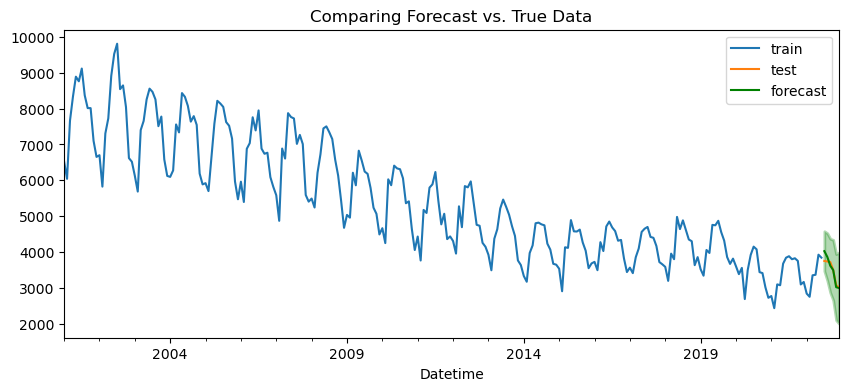

In [83]:
# the auto_arima will store our best nonseasonal and seasonal orders separtely
ns_order=auto_model.order
s_order=auto_model.seasonal_order
# Use auto_arima parameters to fit an ARIMA
auto_model = tsa.ARIMA(train, order=ns_order, seasonal_order=s_order).fit()

# Obtain forecast as a dataframe with confidence intervals
forecast_df = auto_model.get_forecast(steps=len(test)).summary_frame()
# Call the custom function to plot the forecasts with confidence intervals and true values
plot_forecast(train, test, forecast_df);
# Obtain metrics
regression_metrics_ts(test, forecast_df['mean'])

### The auto tuned ARIMA(2,1,0)(1,0,1)[12] is better than the manual model, as auto model shows higher R^2 and lower MAPE
then we Make true future forecasts using the entire dataset (for dates beyond the entire ts)
- Calculate the predicted net change in the number (raw counts) of this type of crime from the beginning of the forecast to the end.
- Convert the raw delta into a percent change.

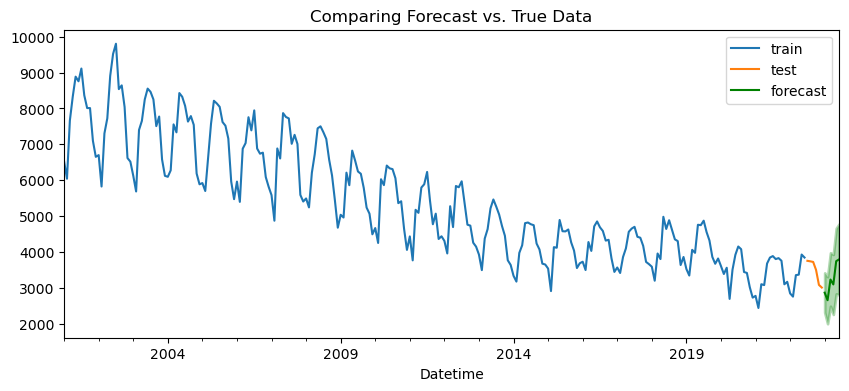

In [85]:
final_model = tsa.ARIMA(ts, order=ns_order, seasonal_order=s_order).fit()
# Obtain future forecasts beyond test data
forecast_df  = final_model.get_forecast(len(test)).summary_frame()
plot_forecast(train,test,forecast_df);

In [86]:
starting_value = forecast_df['mean'].iloc[0]
final_value = forecast_df['mean'].iloc[-1]
change = final_value - starting_value
perc_change = (change / starting_value) * 100
print(f' start:{starting_value}\n end:{final_value}\n change:{change}\n percent change:{perc_change}')

 start:2866.591510653325
 end:3793.4845738678378
 change:926.893063214513
 percent change:32.3343266653038


# Final Evaluation:

After completing both models and getting the forecasts for both crimes for 6 months into the future (beyond the data), 
answer the following questions:

- Of the two crimes, which is forecasted to have the highest monthly count of crimes at the end of the forecast?

``` The forecast indicates that there will be fewer battery-related crimes than thefts.```
- Of the two crimes, which is forecasted to have the highest net change by the end of the forecast?

``` The forecast suggests that there will be a larger increase in battery incidents than in theft.```
- Of the two crimes, which is forecasted to have the highest percent change by the end of the forecast?

``` The forecast indicates that there will be a higher percentage change in battery incidents than in theft.```
# Final Recommendations

Priority on both Crimes: 
- Given that the forecast suggests a higher increase in battery-related crimes, allocate additional resources to tackle and prevent these incidents.
- Given that theft is forecasted to have a higher monthly count of crimes, allocate appropriate resources to address theft-related issues.